This notebook is used to play around with different transpilation options.

#### Play around with other transpilation options just to get an idea of what works well

In [1]:
import scipy
import numpy as np
from matplotlib import pyplot as plt
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter, LieTrotter
from qiskit.transpiler.passes.synthesis.high_level_synthesis import HighLevelSynthesis, HLSConfig
from qiskit.transpiler.passes.synthesis.unitary_synthesis import UnitarySynthesis
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import PassManager, CouplingMap
from qiskit.synthesis import MatrixExponential
from qiskit.quantum_info import Operator
from qiskit.visualization import array_to_latex
from qiskit import Aer, transpile
from qiskit_aer import AerSimulator
# from qiskit_ibm_runtime import QiskitRuntimeService, Estimator
from qiskit.primitives import Estimator, Sampler

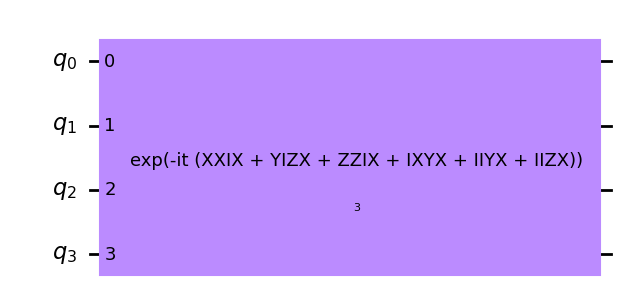

In [2]:
# Make 5-qubit Heisenberg Ham to test and corresponding PauliEvolutionGates.
test_time_evolve = 3
ham_terms = ["XXIX", "YIZX", "ZZIX", "IXYX", "IIYX", "IIZX"]

test_heisenberg_ham = SparsePauliOp(data=ham_terms, 
                                    coeffs=np.ones(len(ham_terms), dtype=int))
test_paulievolutiongate = PauliEvolutionGate(operator=test_heisenberg_ham, 
                                             time=test_time_evolve,
                                             synthesis=MatrixExponential())


# Make initial circuit with PauliEvolutionGate.
qc_before = QuantumCircuit(len(ham_terms[0]))
qc_before.append(test_paulievolutiongate, range(len(ham_terms[0])))

qc_before.draw("mpl", filename="before.png")

In [3]:
array_to_latex(Operator(qc_before).data)

<IPython.core.display.Latex object>

In [4]:
backend = Aer.get_backend("statevector_simulator")
qc_reference = transpile(qc_before, backend)
array_to_latex(Operator(qc_reference).data)

<IPython.core.display.Latex object>

In [5]:
lin_coupling_map = CouplingMap([[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2]])
pm_other = generate_preset_pass_manager(optimization_level=2, 
                                        layout_method="trivial",
                                        coupling_map=lin_coupling_map, 
                                        approximation_degree=1,
                                        routing_method="sabre",
                                        translation_method="unroller",
                                        basis_gates="['u1', 'u2', 'u3', 'cx']",
                                        seed_transpiler=1)

In [6]:
pm_other.init.passes()

[{'passes': [<qiskit.transpiler.passes.utils.contains_instruction.ContainsInstruction at 0x2531183aef0>],
  'flow_controllers': {}},
 {'passes': [<qiskit.transpiler.passes.utils.error.Error at 0x253118388e0>],
  'flow_controllers': {'condition'}},
 {'passes': [<qiskit.transpiler.passes.synthesis.unitary_synthesis.UnitarySynthesis at 0x25311811f90>],
  'flow_controllers': {}},
 {'passes': [<qiskit.transpiler.passes.synthesis.high_level_synthesis.HighLevelSynthesis at 0x25311812ef0>],
  'flow_controllers': {}},
 {'passes': [<qiskit.transpiler.passes.basis.unroll_3q_or_more.Unroll3qOrMore at 0x25311812ce0>],
  'flow_controllers': {}}]

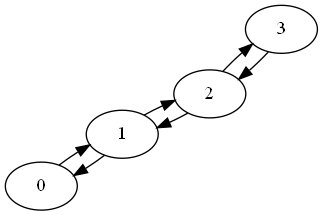

In [7]:
lin_coupling_map.draw()

In [8]:
hls_config = HLSConfig(PauliEvolution=[("cartan", {"random_seed":-1, "involution":"knejaGlaser"})])
pm_hls = PassManager()
pm_hls.append(HighLevelSynthesis(hls_config=hls_config))
qc_hls = pm_hls.run(qc_before) 

Running Cartan Synthesis Plugin...
Optimization terminated successfully.
         Current function value: -2.824917
         Iterations: 224
         Function evaluations: 242
         Gradient evaluations: 242
--- 15.848127126693726 seconds ---
Optimization Error:
9.332917508284947e-10


In [9]:
array_to_latex(Operator(qc_before).data)

<IPython.core.display.Latex object>

In [10]:
array_to_latex(Operator(qc_hls).data)

<IPython.core.display.Latex object>

In [11]:
np.trace(Operator(qc_hls).data @ Operator(qc_before).data.conjugate().T)/(2**len(ham_terms[0]))

(0.999999998892771-2.88363896563254e-17j)

In [12]:
# qc_hls.draw("mpl")

In [13]:
qc_i = pm_other.init.run(qc_hls)
# display(qc_i.draw("mpl"))
# qc_i.count_ops()
np.trace(Operator(qc_i).data @ Operator(qc_before).data.conjugate().T)/(2**len(ham_terms[0]))

# pm_other.init.passes()

(0.9999999988927717-3.053320840791258e-17j)

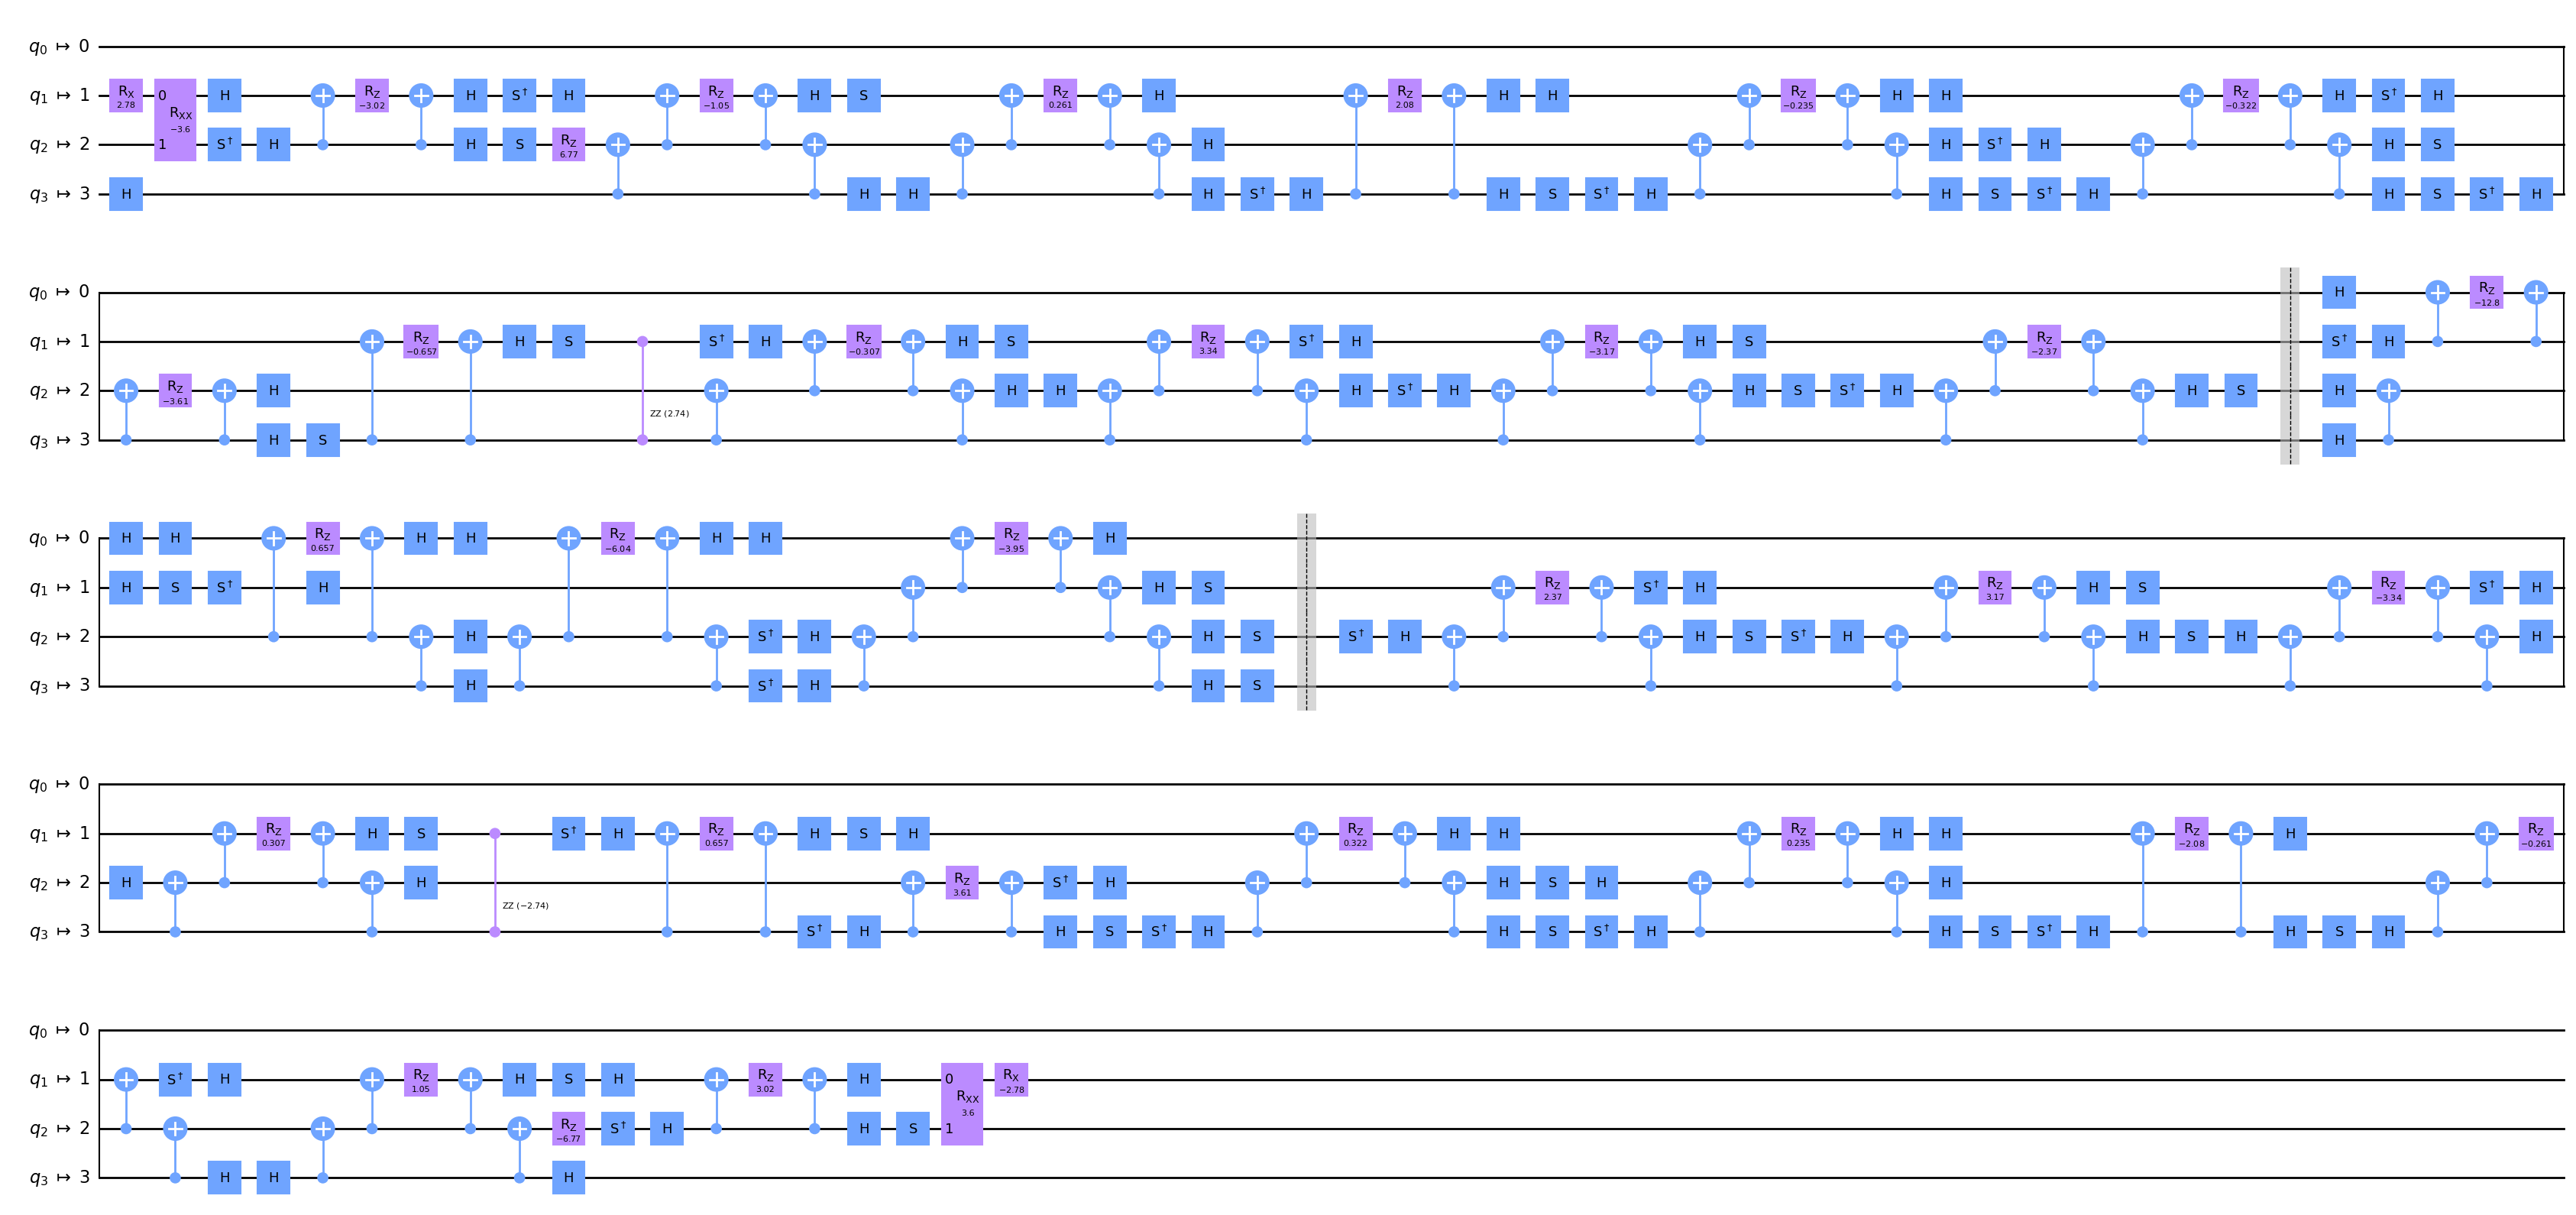

(0.9999999988927717-3.053320840791258e-17j)

In [14]:
qc_l = pm_other.layout.run(qc_i) #replace arg with qc_i if init stage included
display(qc_l.draw("mpl", fold=50))
# qc_l.count_ops()
np.trace(Operator(qc_l).data @ Operator(qc_before).data.conjugate().T)/(2**len(ham_terms[0]))

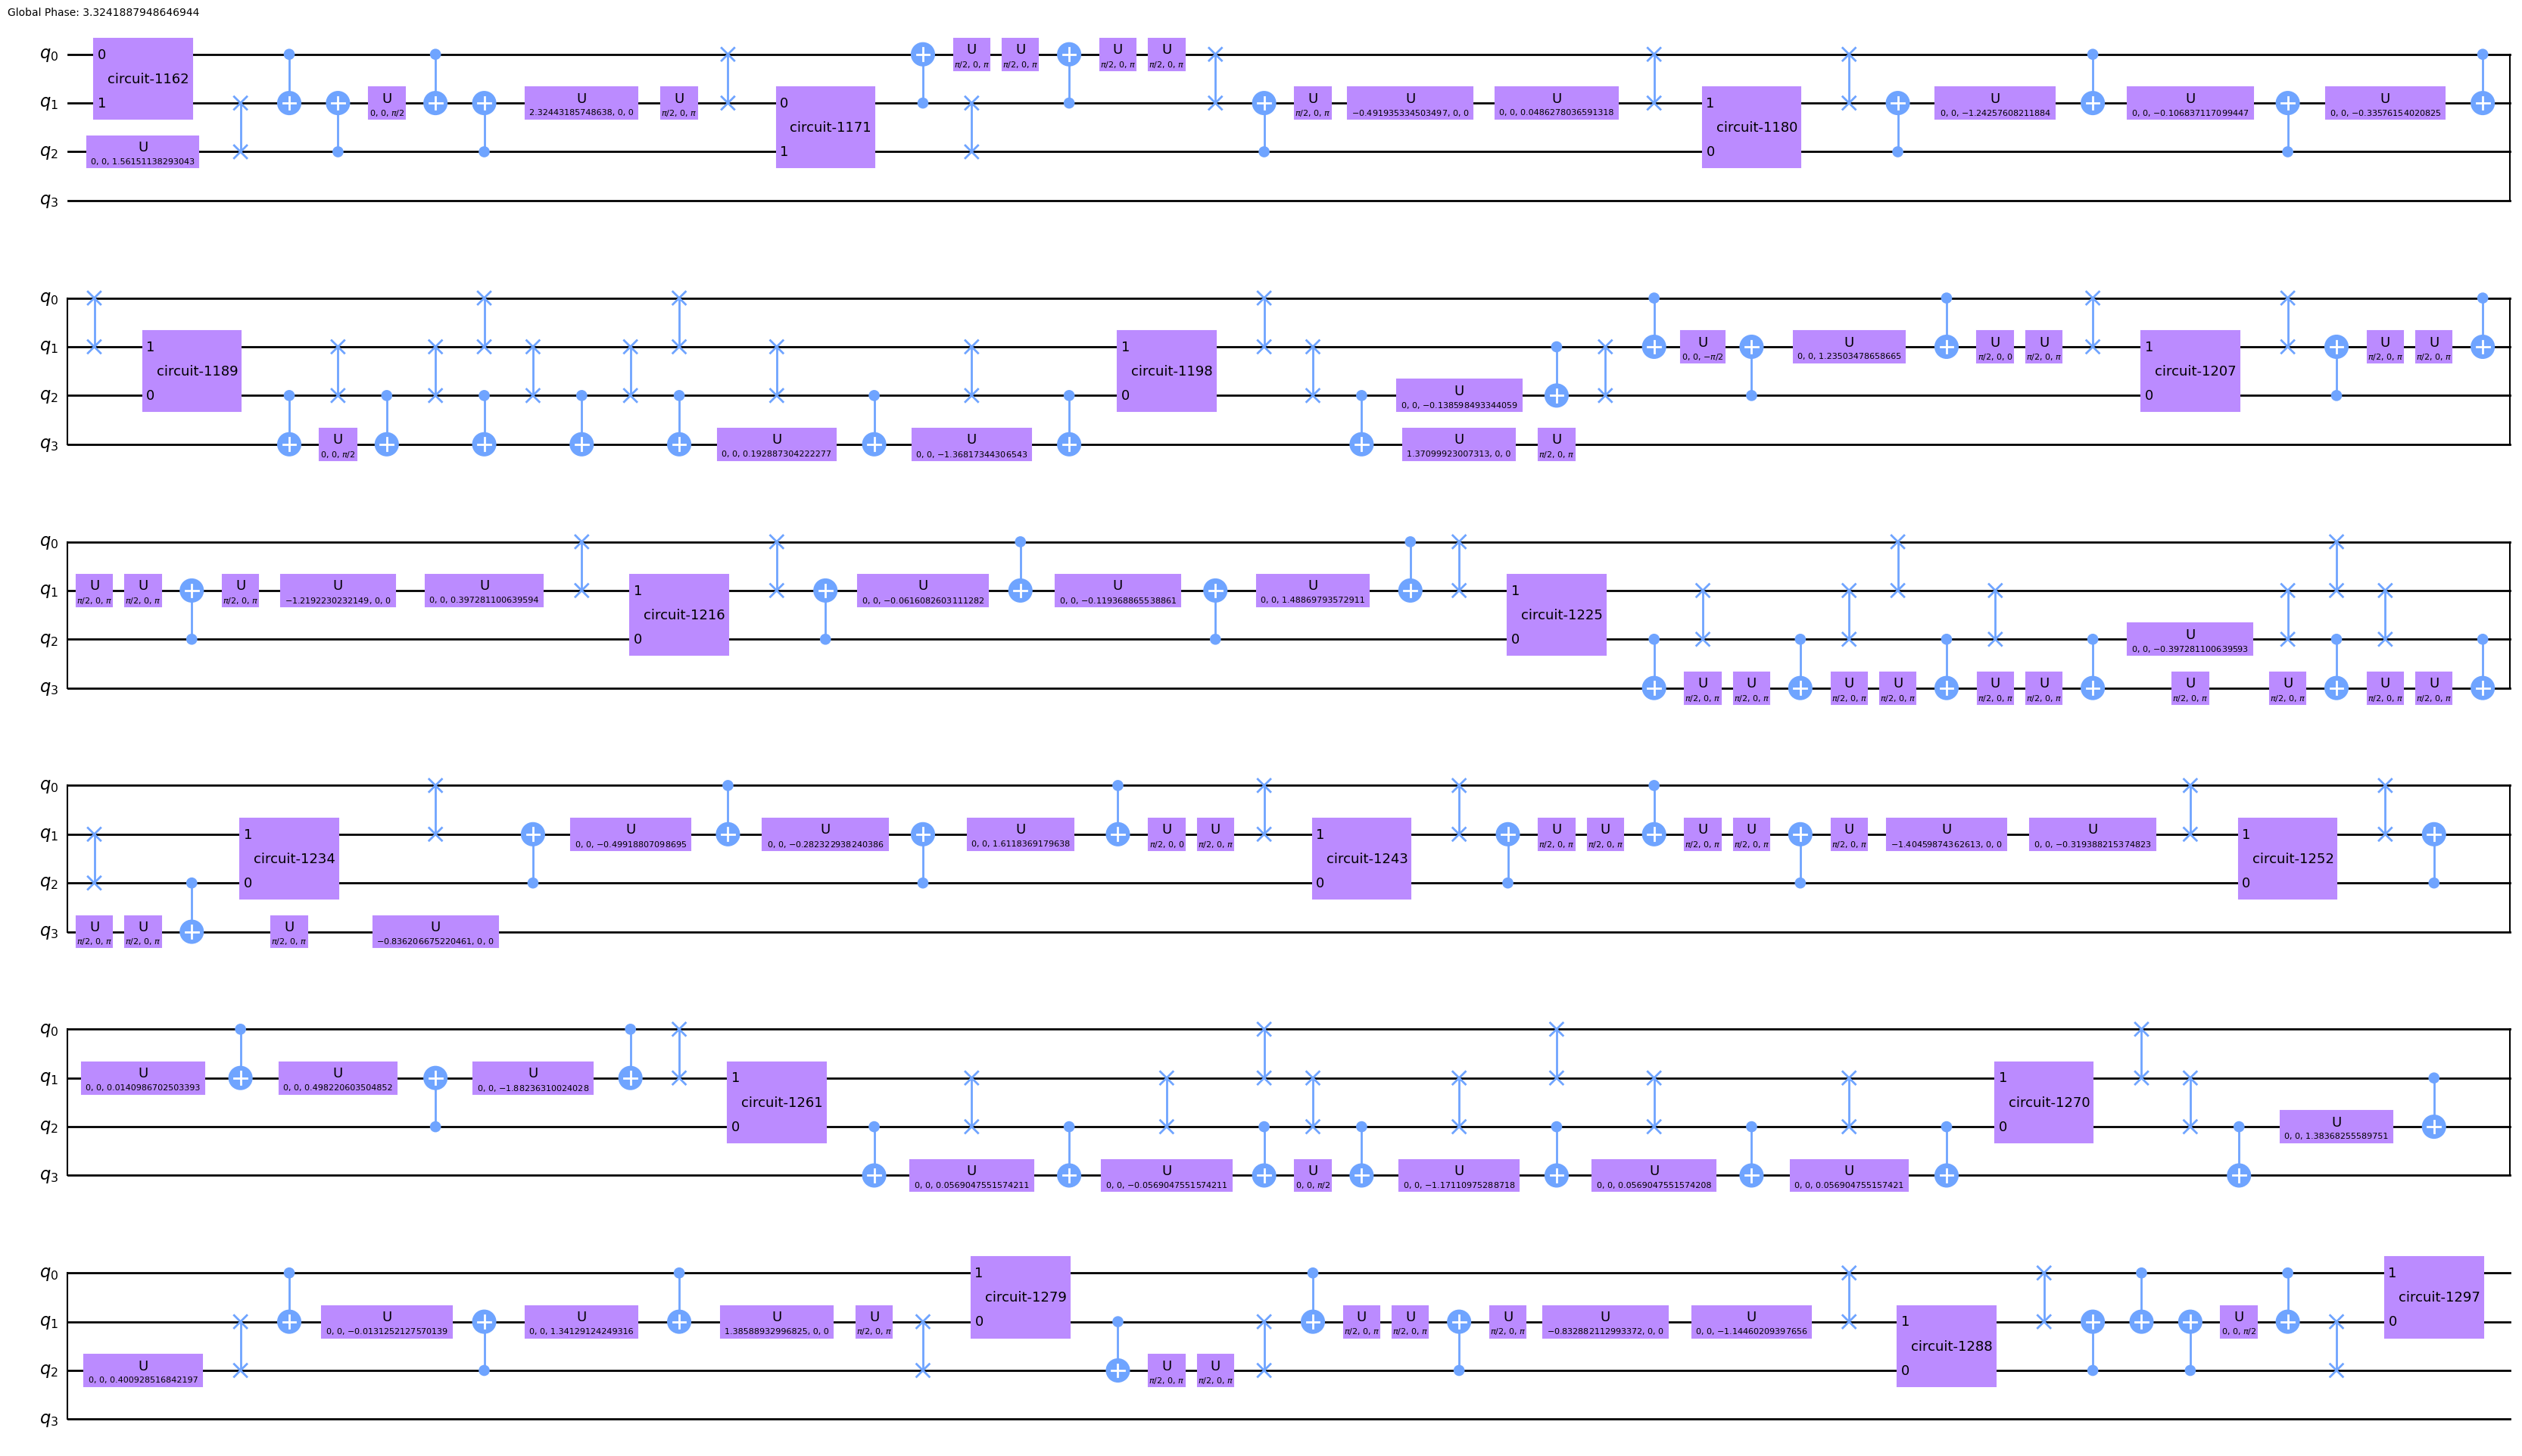

0.5000000000000019

In [42]:
qc_r = pm_other.routing.run(qc_l)
display(qc_r.draw("mpl", fold=50))
# qc_r.count_ops()
np.abs(np.trace(Operator(qc_r).data @ Operator(qc_l).data.conjugate().T))/(2**len(ham_terms[0]))

In [51]:
from mqt import qcec

qcec.verify(qc_l, qc_r)

{
  "check_time": 0.0082178,
  "equivalence": "not_equivalent",
  "parameterized": {
    "performed_instantiations": 0
  },
  "preprocessing_time": 0.001244,
  "simulations": {
    "performed": 0,
    "started": 10
  }
}

In [17]:
array_to_latex(Operator(qc_before).data, max_size=16)

<IPython.core.display.Latex object>

In [18]:
array_to_latex(Operator(qc_r).data, max_size=16)

<IPython.core.display.Latex object>

In [19]:
qc_t = pm_other.translation.run(qc_r)
# display(qc_t.draw("mpl"))
qc_t.count_ops()

OrderedDict([('cx', 134), ('u2', 112), ('u1', 90), ('u3', 2), ('barrier', 2)])

In [20]:
qc_o = pm_other.optimization.run(qc_t)
# display(qc_o.draw("mpl"))
qc_o.count_ops()

OrderedDict([('cx', 112), ('u', 62), ('u1', 32), ('u2', 16), ('barrier', 2)])

In [21]:
array_to_latex(Operator(qc_o).data)

<IPython.core.display.Latex object>

In [22]:
array_to_latex(Operator(qc_before).data)

<IPython.core.display.Latex object>

# Appendix: run all the stages of the passmanager except don't do the cartan decomp to begin with

we see that for small number of qubits, the default transpilation for unroll3qormore (using column by column decomp outlined by https://arxiv.org/pdf/1501.06911.pdf) works better than.

In [23]:
array_to_latex(Operator(qc_before).data)

<IPython.core.display.Latex object>

In [24]:
pm_other.init.passes()

[{'passes': [<qiskit.transpiler.passes.utils.contains_instruction.ContainsInstruction at 0x2531183aef0>],
  'flow_controllers': {}},
 {'passes': [<qiskit.transpiler.passes.utils.error.Error at 0x253118388e0>],
  'flow_controllers': {'condition'}},
 {'passes': [<qiskit.transpiler.passes.synthesis.unitary_synthesis.UnitarySynthesis at 0x25311811f90>],
  'flow_controllers': {}},
 {'passes': [<qiskit.transpiler.passes.synthesis.high_level_synthesis.HighLevelSynthesis at 0x25311812ef0>],
  'flow_controllers': {}},
 {'passes': [<qiskit.transpiler.passes.basis.unroll_3q_or_more.Unroll3qOrMore at 0x25311812ce0>],
  'flow_controllers': {}}]

In [25]:
# Get the third pass from the list
# pass_to_run = pm_other.init.passes()[4]['passes'][0]

# Create a new PassManager with only the desired pass
# new_pass_manager = PassManager(pass_to_run)

# Run the pass
# result = new_pass_manager.run(qc_before) 
# result..draw("mpl")

In [26]:
# pass_to_run.name

In [27]:
qc_i = pm_other.init.run(qc_before)
# display(qc_i.draw("mpl"))
qc_i.count_ops()
array_to_latex(Operator(qc_i).data)

<IPython.core.display.Latex object>

In [28]:
np.trace(Operator(qc_i).data @ Operator(qc_before).data.conjugate().T)/(2**len(ham_terms[0]))

(1.0000000000000018+4.0580100929379925e-14j)

In [29]:
qc_l = pm_other.layout.run(qc_i) #replace arg with qc_i if init stage included
# display(qc_l.draw("mpl"))
qc_l.count_ops()
array_to_latex(Operator(qc_l).data)

<IPython.core.display.Latex object>

In [30]:
np.trace(Operator(qc_l).data @ Operator(qc_before).data.conjugate().T)/(2**len(ham_terms[0]))

(1.0000000000000018+4.0580100929379925e-14j)

In [31]:
qc_r = pm_other.routing.run(qc_l)
# display(qc_r.draw("mpl"))
qc_r.count_ops()
array_to_latex(Operator(qc_r).data)

<IPython.core.display.Latex object>

In [32]:
np.abs(np.trace(Operator(qc_r).data @ Operator(qc_before).data.conjugate().T))/(2**len(ham_terms[0]))

0.500000000000001

In [33]:
qcec.verify(qc_before, qc_r)

{
  "check_time": 0.0081085,
  "equivalence": "not_equivalent",
  "parameterized": {
    "performed_instantiations": 0
  },
  "preprocessing_time": 0.0012435,
  "simulations": {
    "performed": 0,
    "started": 10
  }
}

In [34]:
qc_t = pm_other.translation.run(qc_r)
# display(qc_t.draw("mpl"))
qc_t.count_ops()

OrderedDict([('cx', 258), ('u3', 96), ('u', 84)])

In [35]:
qc_o = pm_other.optimization.run(qc_t)
# display(qc_o.draw("mpl"))
qc_o.count_ops()

OrderedDict([('cx', 238), ('u3', 92), ('u', 55)])

In [36]:
array_to_latex(Operator(qc_o).data)

<IPython.core.display.Latex object>

In [37]:
# Compare with pre-transpiled circuit
array_to_latex(Operator(qc_before).data)


<IPython.core.display.Latex object>

In [38]:
np.abs(np.trace(Operator(qc_o).data @ Operator(qc_before).data.conjugate().T))/(2**len(ham_terms[0]))

0.4999999999999999

In [39]:
# QiskitRuntimeService.save_account(channel="ibm_quantum", 
#                                   token='219d6c8d75d6eac3417ed9bc50414b42b1b464ded94ed3f48dd8cfb16e85366e1b4e707dec6bb127ab03b3223e0f9c41a405f6ebcdb7275bb98f9f1b287016c3', 
#                                   instance="ibm-q/open/main",
#                                   overwrite=True)
# QiskitRuntimeService.saved_accounts()